Sources:

https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184
https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from google.colab import drive
import pickle

drive.mount('/content/drive/')

def load_pickle(path):
    with open(path, 'rb') as f:
        file = pickle.load(f)
        print ('Loaded %s..' %path)
        return file

dataset_directory = '/content/drive/My Drive/Colab Notebooks/tweet-emotion-detection/language_dataset'

emotions = ['anger', 'fear', 'joy', 'sadness']

tweets_train = np.load(join(dataset_directory, 'text_train_tweets.npy'))
labels_train = np.load(join(dataset_directory, 'text_train_labels.npy'))
vocabulary = load_pickle(join(dataset_directory, 'text_word_to_idx.pkl'))

tweets_val = np.load(join(dataset_directory, 'text_val_tweets.npy'))
labels_val = np.load(join(dataset_directory, 'text_val_labels.npy'))

tweets_test_public = np.load(join(dataset_directory, 'text_test_public_tweets_rand.npy'))

print(len(vocabulary))
idx_to_word = {i: w for w, i in vocabulary.items()}
for i in range(7):
  print(i, idx_to_word[i])

sample = 1  ## YOU CAN TRY OUT OTHER TWEETS

print('sample tweet, stored form:')
print(tweets_train[sample])
print(labels_train[sample])

print('sample tweet, readable form:')
decode = []
#tweet_string
for i in range(50):
  decode.append(idx_to_word[tweets_train[sample][i]])
print(decode)
print(emotions[labels_train[sample]])

print("\nPossible words for each feature:", len(vocabulary))
print("Training data X:", tweets_train.shape)
print("Training data y:", labels_train.shape)
print("Val data X:", tweets_val.shape)
print("Val data y:", labels_val.shape)
print("Test data X:", tweets_test_public.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Loaded /content/drive/My Drive/Colab Notebooks/tweet-emotion-detection/language_dataset/text_word_to_idx.pkl..
13978
0 <NULL>
1 <START>
2 <END>
3 it
4 makes
5 me
6 so
sample tweet, stored form:
[ 1 23 24 20 25 19 26 27 28  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
0
sample tweet, readable form:
['<START>', 'lol', 'adam', 'the', 'bull', 'with', 'his', 'fake', 'outrage', '<END>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>']

In [0]:
# create a test submission file with all tweets predicted as 'anger' (1)
y_test_predict_np = np.c_[np.array(range(1, 4065)).astype(int), np.ones(4064).astype(int)]
y_test_predict = pd.DataFrame(y_test_predict_np, columns=["ID", "Prediction"])
y_test_predict.to_csv(join(dataset_directory, "42592380-conv.csv"), index=False)

### Data Exploration

How many times does each emotion appear in the training set? Are the classes well balanced?


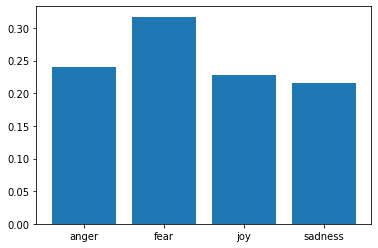

In [121]:
emotion_nums, counts = np.unique(labels_train, return_counts=True)
plt.bar(emotions, counts/len(labels_train));

# Answer: the classes are reasonably well balanced

Are the tweets for different emotions of similar length on average?

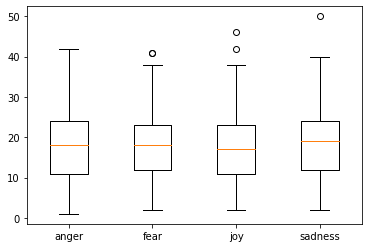

In [122]:
# Count number of words per tweet. The tweets include items that are not words like <START>, <END> and <NULL>. Don't
# include these in the count.
tweets_train_wordcount = []
for tweet in tweets_train:
  word_count = 0
  for vocab_idx in tweet:
    word = idx_to_word[vocab_idx]
    if word not in ['<START>', '<END>', '<NULL>']:
      word_count += 1
  tweets_train_wordcount.append(word_count)
tweets_train_wordcount = np.array(tweets_train_wordcount)

# box-plots
anger = tweets_train_wordcount[np.array(labels_train==0)]
fear = tweets_train_wordcount[np.array(labels_train==1)]
joy = tweets_train_wordcount[np.array(labels_train==2)]
sadness = tweets_train_wordcount[np.array(labels_train==3)]

plt.boxplot([anger, fear, joy, sadness]);
plt.xticks([1, 2, 3, 4], emotions);

# # Answer: yes, the distribution of tweet lengths and the mean tweet length is similar for the 4 emotions

## Data pre-processing:

Remove >2 of a letter, correct spelling, fix slang

In [0]:
# import re

# def reduce_lengthening(text):
#     pattern = re.compile(r"(.)\1{2,}")
#     return pattern.sub(r"\1\1", text)

# word = "aweeeeesomeeee"
# word = reduce_lengthening(word)
# # print(word)

De-emoji, remove hashtags, stop words, punctuation and lemmatize the tweets:

In [124]:
# Sources - from the uni notes:

!pip install emoji --upgrade
import emoji

import string
from collections import defaultdict

import nltk
nltk.download(['stopwords', 'punkt', 'wordnet', 'averaged_perceptron_tagger'])
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet as wn

tag_map = defaultdict(lambda : wn.NOUN); tag_map['J'] = wn.ADJ; tag_map['V'] = wn.VERB; tag_map['R'] = wn.ADV

def normalise_tweets(tweets):
  lemmatizer = WordNetLemmatizer()
  stop_punct = stopwords.words('english') + list(string.punctuation)
  
  normalised_tweets = []
  for tweet in tweets:

    # Step 1 - the tweets are currently indexes. this loop converts them to a list of words without the '<START>', '<END>', '<NULL>'
    # and '<user>' which are useless. It also uses word_tokenize which will split off hashtags - e.g. '#tag' becomes '# tag'. It
    # also uses the emoji package to convert emoji pictures into words as these could be valuable.
    tweet_words = []
    for vocab_idx in tweet:
      word = emoji.demojize(idx_to_word[vocab_idx])
      if word == '<END>': break
      if word not in ['<START>', '<NULL>', '<user>']:
        tweet_words += word_tokenize(word) # word_tokenize splits off the hashtags
    
    # Step 2 - for the tweets constructed in the first loop, the following loop tags them, then removes punctuation and digtits and
    # short words and then finally lemmatizes the word. It re-constructs the tweet as a string.
    normalised_tweet = ""
    for word, tag in pos_tag(tweet_words):
      if word not in stop_punct and not word.isdigit() and len(word) > 2:
        pos = tag_map[tag[0]]
        normalised_tweet = normalised_tweet + lemmatizer.lemmatize(word, pos) + ' '

    normalised_tweets.append(normalised_tweet)
  return normalised_tweets

tweets_train_normalised = normalise_tweets(tweets_train)
tweets_val_normalised = normalise_tweets(tweets_val)
tweets_test_normalised = normalise_tweets(tweets_test_public)
tweets_normalised = tweets_train_normalised + tweets_val_normalised

tweets_train_normalised[1:5]

Requirement already up-to-date: emoji in /usr/local/lib/python3.6/dist-packages (0.5.4)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['lol adam bull fake outrage ',
 'pass away early morning fast furious styled car crash leave atl strip club rough stuff ',
 'lol wow gon say really haha see chris nah dont even snap anymore dude ',
 'need bento_box sushi date rice_ball spaghetti olive guard date cheese_wedge oncoming_fist medium_light_skin_tone rockys date pizza ']

## Feature engineering:

Vectorise the words using a TF-IDF approach:

In [0]:
# shuffle the training set and validation set. the data is ordered by emotion so needs shuffling if I am going to use
# cross-validation for a grid search later on.

train_set = np.c_[tweets_train_normalised, labels_train]
np.random.shuffle(train_set)
tweets_train_normalised_shuffled = train_set[:, 0]

val_set = np.c_[tweets_val_normalised, labels_val]
np.random.shuffle(val_set)
tweets_val_normalised_shuffled = val_set[:, 0]

tweets_normalised_shuffled = np.concatenate((tweets_train_normalised_shuffled, tweets_val_normalised_shuffled))

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer
import copy

# there are 7098 tweets in the dataset, hence limit to the features to something reasonable. Start with 3500.
tfidf_train = TfidfVectorizer(ngram_range=(1, 2), max_features=3500)
X_train = tfidf_train.fit_transform(train_set[:, 0])
X_val = tfidf_train.transform(val_set[:, 0])
y_train = train_set[:,1]
y_val = val_set[:,1]

tfidf_all = copy.deepcopy(tfidf_train)
X = tfidf_all.fit_transform(tweets_normalised_shuffled)
y = np.concatenate([y_train, y_val])
X_test = tfidf_all.transform(tweets_test_normalised)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X.shape, y.shape, X_test.shape

((7098, 3500),
 (7098,),
 (1460, 3500),
 (1460,),
 (8558, 3500),
 (8558,),
 (4064, 3500))

# Train conventional ML models:

Fear is the majority class in the training data. Hence, a majority class classifier trained on the training data would always pick fear. Per below, fear is 26.5% of the validation set so is the accuracy of a majority class classifier when making predictions on the validation data.

In [293]:
emotion_nums, counts = np.unique(labels_val, return_counts=True)
emotions, counts/len(labels_val)

(['anger', 'fear', 'joy', 'sadness'],
 array([0.26506849, 0.26575342, 0.19794521, 0.27123288]))

Fit a Naive Bayes classifier to give a baseline for performance measurement on other models. 43% accuracy is a big improvement on the majority class classifier:

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()#fit_prior=False)
nb_clf.fit(X_train, y_train)
print("Training accuracy:", accuracy_score(y_train, nb_clf.predict(X_train)), "\n",
      "Validation Accuracy:", accuracy_score(y_val, nb_clf.predict(X_val)))

Training accuracy: 0.9119470273316427 
 Validation Accuracy: 0.43424657534246575


Try several candidate models with default settings to see which might be worth investigating further:

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC

models = {"Naive Bayes" : MultinomialNB(),
          "KNN" : KNeighborsClassifier(n_neighbors = 10),
          "Logistic Reg" : LogisticRegression(multi_class='ovr', max_iter=500),
          "Softmax" : LogisticRegression(multi_class='multinomial', solver='lbfgs'),
          "Linear SVM" : LinearSVC(),
          "Non-Linear SVM" : SVC(),
          "Random Forest" : RandomForestClassifier(random_state=0),
          "Grad. Boosting" : GradientBoostingClassifier()}

KNN does not scale well when the number of features is high relative to the number of instances so performs poorly on both training and validation set. The other models perform very well on the training set but not very well on the validation set which suggests overfitting.


In [18]:
from IPython.display import display

def run_models(models_dict, X_train, y_train, X_val, y_val):
  training_accuracies = []
  validation_accuracies = []
  column_titles = []
  for model_name, model in models_dict.items():
    column_titles.append(model_name)
    model.fit(X_train, y_train)
    training_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
    validation_accuracies.append(accuracy_score(y_val, model.predict(X_val)))

  display(pd.DataFrame(np.c_[np.round(training_accuracies, 4), np.round(validation_accuracies, 4)].transpose(),
                       columns=column_titles, index=["Training data", "Validation data"]))

run_models(models, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Naive Bayes,KNN,Logistic Reg,Softmax,Linear SVM,Non-Linear SVM,Random Forest,Grad. Boosting
Training data,0.9119,0.3724,0.9310,0.9424,0.9658,0.9687,0.9720,0.8370
Validation data,0.4342,0.2836,0.4507,0.4486,0.4459,0.4473,0.4452,0.4212


Use grid search with the linear SVM to see if the model paramaters (and pre-processing parameters) can be tweaked to reduce overfitting.

Result: the accuracy for the 12 models is >75% but only ~50% on the 5th fold. The 5th fold contains mostly data from the validation set. Therefore, the overfitting may be largely due to feature engineering or data mistmatch.

In [275]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

linearsvm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC())
])

linearsvm_grid = [{
    'tfidf__ngram_range':[(1,1), (1,2)],
    'tfidf__max_features':[500, 1000, 3500],
    'svc__C':[0.01, 0.1, 1, 10]
}]

grid_search = GridSearchCV(linearsvm_pipeline, linearsvm_grid, cv=5, scoring='accuracy')
grid_search.fit(tweets_normalised_shuffled, y)
print("Best model based on CV scores:", grid_search.best_params_, "\n")

models_df = pd.DataFrame(scores["params"])
scores_df = pd.DataFrame(np.c_[np.array(all_scores).transpose(), np.round(scores["mean_test_score"], 2)],
                         columns=['1', '2', '3', '4', '5', 'Avg'])
pd.concat([models_df, scores_df], axis=1)

Best model based on CV scores: {'svc__C': 0.1, 'tfidf__max_features': 3500, 'tfidf__ngram_range': (1, 1)} 



,svc__C,tfidf__max_features,tfidf__ngram_range,1,2,3,4,5,Avg
0,0.01,500,"(1, 1)",0.74,0.72,0.73,0.72,0.50,0.68
1,0.01,500,"(1, 2)",0.73,0.72,0.72,0.72,0.50,0.68
2,0.01,1000,"(1, 1)",0.75,0.75,0.74,0.74,0.49,0.69
3,0.01,1000,"(1, 2)",0.75,0.75,0.74,0.74,0.49,0.70
4,0.01,3500,"(1, 1)",0.69,0.70,0.69,0.70,0.49,0.65
5,0.01,3500,"(1, 2)",0.69,0.70,0.69,0.70,0.49,0.66
6,0.10,500,"(1, 1)",0.77,0.75,0.77,0.75,0.50,0.71
7,0.10,500,"(1, 2)",0.76,0.75,0.75,0.75,0.50,0.70
8,0.10,1000,"(1, 1)",0.83,0.82,0.82,0.80,0.51,0.76
9,0.10,1000,"(1, 2)",0.83,0.81,0.82,0.80,0.51,0.76


Kaggle returns a score of 60% for the linear svm from above on the test data. The model is trained on the full data (training + validation) so is better than the model trained on the training data only.

In [316]:
def create_submission_file(model, X, y, X_test):
  model.fit(X, y)
  y_test_predict_np = np.c_[np.array(range(1, 4065)).astype(int), model.predict(X_test)]
  y_test_predict = pd.DataFrame(y_test_predict_np, columns=["ID", "Prediction"])
  y_test_predict.to_csv(join(dataset_directory, "42592380-conv.csv"), index=False)
  return accuracy_score(y, model.predict(X))

create_submission_file(grid_search.best_estimator_, tweets_normalised_shuffled, y, tweets_test_normalised)

0.8673755550362234

Perform error analysis on the validation set using a selection of the candidate models to see what is going wrong with the predictions on the validation set. Per output from the below code cell:

- All models have higher accuracy/recall on fear and joy than anger and sadness.
- All models have low accuracy/recall (30-40%) on sadness
- All the models have similar error patterns. A voting classifier may not be beneficial.
- The fear class has low precision, i.e. many non-fear tweets are mistakenly classified as fear (over 40% of anger and sadness tweets in most models).
- **The decision boundary estimated from the training data separates the classes almost perfectly in the training data but poorly in the validation set. The features deemed significant in predicting the emotions have not generalised well to the validation set (i.e. the model has overfit to features that define fear in the training set but are related to other emotions in the validation set).**

In [239]:
from sklearn.metrics import confusion_matrix

for model_name in ['Naive Bayes', 'Logistic Reg', 'Linear SVM', 'Random Forest']:
  model = models[model_name]
  y_val_predict = model.predict(X_val)
  cmtrx = confusion_matrix(y_val, y_val_predict)

  cmtrx = cmtrx / cmtrx.sum(axis=1, keepdims=True)
  df = pd.DataFrame(np.round(cmtrx,2), columns=[[model_name] * 4, ["Predicted"] * 4, emotions], 
                       index=[["Actual"] * 4, emotions])
  display(df)
  print("\n")

Naive Bayes                    
                 Predicted                    
                     anger  fear   joy sadness
Actual anger          0.38  0.42  0.06    0.13
       fear           0.18  0.64  0.05    0.13
       joy            0.10  0.34  0.47    0.09
       sadness        0.20  0.47  0.07    0.26

Logistic Reg                    
                  Predicted                    
                      anger  fear   joy sadness
Actual anger           0.39  0.40  0.06    0.16
       fear            0.19  0.60  0.05    0.15
       joy             0.09  0.33  0.51    0.08
       sadness         0.20  0.41  0.07    0.32

Linear SVM                    
                Predicted                    
                    anger  fear   joy sadness
Actual anger         0.40  0.36  0.06    0.18
       fear          0.20  0.56  0.06    0.18
       joy           0.11  0.29  0.51    0.09
       sadness       0.21  0.38  0.07    0.34

Random Forest                    
                   Predicted                    
                       anger  fear   joy sadness
Actual anger            0.37  0.42  0.05    0.16
       fear             0.19  0.62  0.04    0.16
       joy              0.06  0.43  0.46    0.05
       sadness          0.18  0.43  0.06    0.33

Most important features are determined from the Logistic Regression to see if the model is giving significane to noise rather than true signals. The 10 most informative features for each emotion are displayed. The results make sense. However, some of the top words for fear such as 'awful' 'terrible' 'horrible' could easily be associated with anger or sadness.

In [240]:
# This idea came from:
# https://towardsdatascience.com/how-i-improved-my-text-classification-model-with-feature-engineering-98fbe6c13ef3

feature_names = np.array(tfidf_train.get_feature_names()).reshape(-1,1)

# make sure the model is the original one
lr_clf = models['Logistic Reg']
lr_clf.fit(X_train, y_train)
weights = np.round(lr_clf.coef_.transpose(), 3)

feature_importances = pd.DataFrame(weights, columns=emotions)
feature_importances.insert(0, 'Feature', feature_names)

for emotion in emotions:
  display(feature_importances.nlargest(10, emotion)[['Feature', emotion]])
  print("\n")

,Feature,anger
2132,offend,6.193
95,angry,5.804
89,anger,5.786
2455,rage,5.619
267,bitter,5.587
2556,revenge,5.453
1119,fume,5.076
2185,outrage,4.816
2930,sting,4.705
2826,snap,4.544


,Feature,fear
993,fear,5.211
2025,nervous,5.182
185,awful,5.173
2062,nightmare,5.088
2727,shake,5.020
356,bully,4.945
3050,terrible,4.901
3057,terrorism,4.873
1450,horrible,4.814
1454,horror,4.753


,Feature,joy
1421,hilarious,6.018
2515,rejoice,5.938
2811,smile,5.809
2166,optimism,5.801
455,cheer,5.774
1344,happy,5.135
1669,laughter,5.126
1194,glee,5.082
1744,lively,4.782
2315,playful,4.417


,Feature,sadness
287,blue,6.317
707,depression,5.925
2833,sober,5.883
704,depress,5.717
2616,sadness,5.644
3261,unhappy,5.500
2611,sad,5.412
657,dark,5.379
2784,sink,5.247
2712,serious,5.111


Look more closely at the errors for the first 15 tweets in the validation set. The probabilities are hardly ever over 50%. The classifier is not very certain!

In [241]:
logreg_clf = models['Logistic Reg']
y_val_predict = model.predict(X_val)

num_tweets = 15
decision_scores = np.round(logreg_clf.predict_proba(X_val)[0:num_tweets], 2)
actual_emotions = [emotions[int(emotion_num)] for emotion_num in y_val[0:num_tweets]]
predicted_emotions = [emotions[int(emotion_num)] for emotion_num in y_val_predict[0:num_tweets]]
tweets = tweets_val_normalised_shuffled[0:num_tweets]

pd.DataFrame(np.c_[decision_scores, actual_emotions, predicted_emotions, tweets], columns = emotions + ['Actual', 'Predicted', 'Tweet'])

,anger,fear,joy,sadness,Actual,Predicted,Tweet
0,0.58,0.12,0.1,0.19,anger,anger,understand woman wrath real rise
1,0.23,0.47,0.19,0.11,sadness,fear,pay couple new find glory ticket gon great sta...
2,0.45,0.22,0.18,0.15,anger,anger,mint often indignant
3,0.03,0.02,0.93,0.02,joy,joy,smile repeat happy smile
4,0.07,0.76,0.06,0.12,sadness,fear,tonight run restless
5,0.47,0.29,0.14,0.1,anger,anger,suppose people people seem struggle
6,0.39,0.14,0.34,0.12,sadness,anger,follow show keep laugh guest sit elongate
7,0.06,0.52,0.06,0.36,anger,fear,hatred fear many anything non russian sad
8,0.12,0.3,0.14,0.43,sadness,sadness,next time get dreadful good chris
9,0.15,0.23,0.06,0.56,sadness,sadness,imagine suffer chronic depression tell unattra...


## Feature selection:

The models are unlikely to be overfitting due to too much flexibility as some of them are reasonably simple models and they have been fit with the conservative default settings (e.g. by default, the linear svc sets C=1 and logistic regression applies l2 regularisation).

Below I try various feature selection methods to no avail.

*1. Select 1000 best features using chi-sq feature selection:*

Result: training accuracy decreases but validation accuracy remains similar. KNN is much improved though.

In [262]:
# Source: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

from sklearn.feature_selection import SelectKBest, chi2

tfidf_train_2 = TfidfVectorizer(ngram_range=(1, 2))
X_train_2 = tfidf_train_2.fit_transform(tweets_train_normalised_shuffled)
X_val_2 = tfidf_train_2.transform(tweets_val_normalised_shuffled)

chi2_selector = SelectKBest(chi2, k=1000)
X_train_2 = chi2_selector.fit_transform(X_train_2, y_train)
X_val_2 = chi2_selector.transform(X_val_2)
run_models(models, X_train_2, y_train, X_val_2, y_val)

,Naive Bayes,KNN,Logistic Reg,Softmax,Linear SVM,Non-Linear SVM,Random Forest,Grad. Boosting
Training data,0.7570,0.8762,0.8469,0.8650,0.9094,0.9162,0.9511,0.8408
Validation data,0.4288,0.4432,0.4479,0.4507,0.4514,0.4370,0.4473,0.4212


*2. Use a type of dimensionality reduction appropriate for a sparse matrix:*

Result: this method is too slow to run other than on logistic regression and linear SVM. It makes little difference though.

In [263]:
from sklearn.decomposition import TruncatedSVD

tfidf_train_3 = TfidfVectorizer(ngram_range=(1, 2))
X_train_3 = tfidf_train_3.fit_transform(tweets_train_normalised_shuffled)
X_val_3 = tfidf_train_3.transform(tweets_val_normalised_shuffled)

tsvd = TruncatedSVD(n_components=500)
X_train_3 = tsvd.fit_transform(X_train_3)
X_val_3 = tsvd.transform(X_val_3)
models_temp = {model_name: model for model_name, model in models.items() if model_name in ['Logistic Reg', 'Linear SVM']}
run_models(models_temp, X_train_3, y_train, X_val_3, y_val)

,Logistic Reg,Linear SVM
Training data,0.8314,0.8674
Validation data,0.4404,0.4507


*3. Use recursive feature elimination to fit the model with only the most important features from the logistic regression*

Result: no significant difference to other methods

In [264]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=models['Logistic Reg'], n_features_to_select=1000, step=100)
rfe.fit(X_train, y_train)
accuracy_score(y_val, rfe.predict(X_val))

0.4520547945205479

## Use grid-search to find a better model:

Try and fit the model on the validation data only and then make predictions on the validation data with this model. I realise this is sort of cheating but it may provide insights.

Result: the base models trained on the validation data can still only predict ~60% on the validation data. There are only 1460 instances though so maybe this is due to a lack of data.

In [337]:
tfidf_val = TfidfVectorizer(ngram_range=(1, 2), max_features=3500)

X_val_temp = tfidf_val.fit_transform(tweets_val_normalised_shuffled) # re-vectorize with only features from the validation data
X_train_temp = tfidf_val.transform(tweets_train_normalised_shuffled)

for model_name, model in models.items():
  model.fit(X_val_temp, y_val)
  print(model_name, np.round(accuracy_score(y_val, model.predict(X_val_temp)), 4))

# feature_names = np.array(tfidf_val.get_feature_names()).reshape(-1,1)

# lr_clf = models['Logistic Reg']
# lr_clf.fit(X_val_temp, y_val)
# weights = np.round(lr_clf.coef_.transpose(), 3)

# feature_importances = pd.DataFrame(weights, columns=emotions)
# feature_importances.insert(0, 'Feature', feature_names)

# for emotion in emotions:
#   display(feature_importances.nlargest(10, emotion)[['Feature', emotion]])
#   print("\n")


Naive Bayes 0.5911
KNN 0.3548
Logistic Reg 0.589
Softmax 0.5925
Linear SVM 0.6055
Non-Linear SVM 0.6048
Random Forest 0.6075
Grad. Boosting 0.5801


# Train deep learning models:

In [0]:
# function to plot results for different deep learning models

def plot_model_results(history, epochs=100, x_step=5):  
  train_accuracy = history.history['accuracy']
  acc_for_max = train_accuracy

  if 'val_accuracy' in history.history.keys():
    val_accuracy = history.history['val_accuracy']
    plt.plot(np.arange(1, epochs+1), val_accuracy, label='Val acc');
    acc_for_max = val_accuracy

  plt.plot(np.arange(1, epochs+1), train_accuracy, label='Training acc');
  plt.xlabel('Epoch'); plt.ylabel('Accuracy');
  plt.ylim(0, 1.0);
  plt.xticks(np.arange(1, epochs+1, x_step)); plt.yticks(np.arange(0, 1.05, 0.05));
  plt.grid();
  plt.legend();
  max_acc, max_acc_epoch = np.round(np.max(acc_for_max), 4), np.argmax(acc_for_max)+1
  plt.vlines(x=max_acc_epoch, ymin=0, ymax=1, color='gray', label='Max val acc');
  plt.hlines(y=max_acc, xmin=0, xmax=epochs+1, color='gray', label=None);
  plt.annotate(max_acc, (max_acc_epoch, max_acc), textcoords="offset points", xytext=(0,0), ha='center')

  print('Max accuracy', max_acc, 'at epoch', max_acc_epoch, "\n")

### Try a simple dense network:

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import InputLayer, Dense, Dropout, Flatten, Activation, Embedding, GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from functools import partial

In [0]:
def dense_model():
  DenseLayer = partial(Dense, activation='relu', kernel_initializer='he_normal')
  neurons_per_layer = 2500

  model_dense = Sequential([
      InputLayer(input_shape=(3500,)),
      #BatchNormalization(),
      Dropout(0.2),
      DenseLayer(neurons_per_layer),
      #BatchNormalization(),
      Dropout(0.2),
      DenseLayer(neurons_per_layer),
      #BatchNormalization(),
      Dropout(0.2),
      DenseLayer(neurons_per_layer),
      #BatchNormalization(),
      Dropout(0.2),
      Dense(4, activation='softmax', kernel_initializer='glorot_uniform')
  ])   
  return model_dense

In [179]:
model_dense_train = dense_model()
model_dense_train.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_31 (Dropout)         (None, 3500)              0         
_________________________________________________________________
dense_203 (Dense)            (None, 2500)              8752500   
_________________________________________________________________
dropout_32 (Dropout)         (None, 2500)              0         
_________________________________________________________________
dense_204 (Dense)            (None, 2500)              6252500   
_________________________________________________________________
dropout_33 (Dropout)         (None, 2500)              0         
_________________________________________________________________
dense_205 (Dense)            (None, 2500)              6252500   
_________________________________________________________________
dropout_34 (Dropout)         (None, 2500)            

Max validation accuracy of 45.41% is similar to the conventional models. Max accuracy is reached at epoch 40 but is essentially reached at epoch 21 when training accuracy is only 70%. Anything after this I consider overfitting.

Max val accuracy 0.4541 at epoch 40 



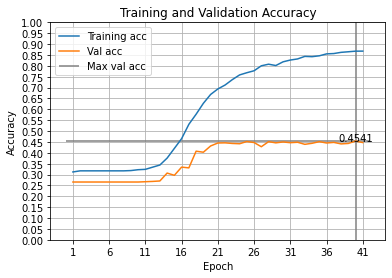

In [180]:
model_dense_train.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model_dense_train.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=False, 
                                callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])
plot_model_results(history, epochs=len(history.history['accuracy']))

Max accuracy 0.8565 at epoch 100 



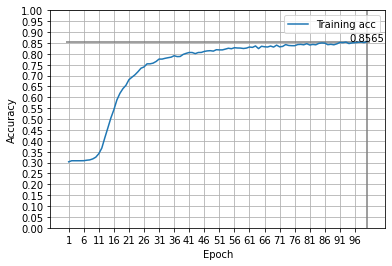

In [196]:
# need to create a new model to fit to X as the previous model is already fit to X_train
model_dense_all = dense_model()
model_dense_all.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
history = model_dense_all.fit(X, y, epochs=100, verbose=False,
                              callbacks=[EarlyStopping(patience=20, restore_best_weights=True, monitor='loss')])
plot_model_results(history, epochs=len(history.history['accuracy']))

In [0]:
pred_dl = np.argmax(model_dense_all.predict(X_test), axis=1)
y_test_predict_np = np.c_[np.array(range(1, 4065)).astype(int), pred_dl]
y_test_predict = pd.DataFrame(y_test_predict_np, columns=["ID", "Prediction"])
y_test_predict.to_csv(join(dataset_directory, "42592380-conv.csv"), index=False)

In [199]:
# compare SVM and dl on the special validation data

pred_dl_val = np.argmax(model_dense_all.predict(X_val_special), axis=1)

models['Linear SVM'].fit(X, y)
pred_conv_val = models['Linear SVM'].predict(X_val_special)

print("SVM acc:", accuracy_score(y_val, pred_conv_val))
print("DL acc:", accuracy_score(y_val.astype(np.int64), pred_dl_val))
print("SVM vs. DL:", accuracy_score(pred_dl_val, pred_conv_val.astype(np.int64)))

SVM acc: 0.5780821917808219
DL acc: 0.6082191780821918
SVM vs. DL: 0.6226027397260274


In [200]:
# dl on the validation data

from sklearn.metrics import confusion_matrix

cmtrx = confusion_matrix(pred_dl_val, y_val.astype(np.int64))
cmtrx = cmtrx / cmtrx.sum(axis=1, keepdims=True)
np.round(cmtrx, 2)

array([[0.46, 0.26, 0.01, 0.27],
       [0.21, 0.54, 0.01, 0.24],
       [0.  , 0.  , 0.97, 0.02],
       [0.14, 0.15, 0.03, 0.68]])

In [201]:
# SVM on the validation data

cmtrx = confusion_matrix(pred_conv_val, y_val)
cmtrx = cmtrx / cmtrx.sum(axis=1, keepdims=True)
np.round(cmtrx, 2)

array([[0.52, 0.23, 0.02, 0.23],
       [0.23, 0.47, 0.05, 0.25],
       [0.02, 0.03, 0.91, 0.04],
       [0.21, 0.22, 0.04, 0.53]])

In [202]:
# compare models on the test data

models['Linear SVM'].fit(X, y)
pred_conv = models['Linear SVM'].predict(X_test)
print(accuracy_score(pred_dl, pred_conv.astype(np.int64)))
print(pred_dl[0:10], pred_conv[0:10])

0.8476870078740157
[3 2 1 3 1 1 3 1 0 3] ['3' '2' '1' '1' '1' '1' '3' '1' '2' '3']


Using an embedding layer instead of BoW:

In [400]:
model_embed = Sequential([
    Embedding(len(vocabulary), 16, mask_zero=True, input_length=52),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])

model_embed.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 52, 16)            223648    
_________________________________________________________________
global_average_pooling1d_11  (None, 16)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_84 (Dense)             (None, 4)                 68        
Total params: 223,988
Trainable params: 223,988
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Max val accuracy 0.4384 at epoch 7 



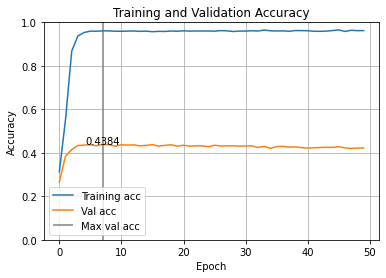

In [401]:
model_embed.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_embed.fit(tweets_train, labels_train, epochs=50, validation_data=(tweets_val, labels_val), verbose=False)
plot_model_results(history)

Use pre-trained embeddings:

In [0]:
import tensorflow_hub as hub
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)

In [406]:
# what is the difference between keras and tf.keras!?
model_pretrain = tf.keras.Sequential([
    hub_layer,
    # GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_pretrain.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_29 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 68        
Total params: 400,424
Trainable params: 400,424
Non-trainable params: 0
_________________________________________________________________


Max val accuracy 0.4075 at epoch 3 



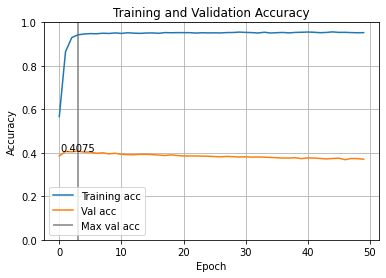

In [407]:
train, val, test = tf.constant(tweets_train_normalised), tf.constant(tweets_val_normalised), tf.constant(tweets_test_normalised)
model_pretrain.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_pretrain.fit(train, labels_train, epochs=50, validation_data=(val, labels_val), verbose=False)
plot_model_results(history)

Use a CNN:

In [410]:
model_cnn = Sequential([
    Embedding(len(vocabulary), 16),

    Conv1D(100, 3, padding='valid', activation='relu', strides=1),
    GlobalMaxPooling1D(),
    
    Dense(100, activation="relu"),
    Dropout(0.5),
    Dense(100, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="softmax"),
])

model_cnn.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 16)          223648    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 100)         4900      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)             

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Max val accuracy 0.4568 at epoch 6 



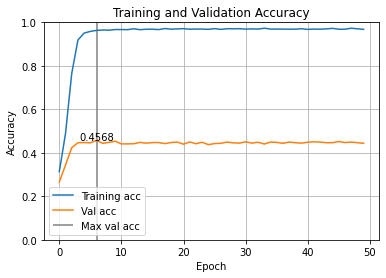

In [411]:
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_cnn.fit(tweets_train, labels_train, epochs=50, validation_data=(tweets_val, labels_val), verbose=False)
plot_model_results(history)

# More data:

In [0]:
# SOURCE: https://tlkh.github.io/text-emotion-classification/

# tweets_train_new_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/tweet-emotion-detection/language_dataset/training_new.csv")
# tweets_train_new = tweets_train_new_df['content']
# y_new = tweets_train_new_df['Emotion']

In [0]:
# def normalise_tweets_2(tweets, labels):
#   lemmatizer = WordNetLemmatizer()
#   stop_punct = stopwords.words('english') + list(string.punctuation)
  
#   normalised_tweets = []
#   new_labels = []

#   index = 0
#   for tweet in tweets:
#     tweet_words = []
#     tweet = tweet.lower()
#     for word in word_tokenize(tweet):
#       if word not in ['<START>', '<END>', '<NULL>', '<user>'] and word in emotion_words:
#         tweet_words += word_tokenize(emoji.demojize(word))

#     normalised_tweet = ""
#     for word, tag in pos_tag(tweet_words):
#       if word not in stop_punct and not word.isdigit():
#         if tag.startswith('NN'):
#             pos = 'n'
#         elif tag.startswith('VB'):
#             pos = 'v'
#         else:
#             pos = 'a'
#         normalised_tweet = normalised_tweet + lemmatizer.lemmatize(word, pos) + ' '
    
#     if len(normalised_tweet) > 0:
#       normalised_tweets.append(normalised_tweet)
#       new_labels.append(labels[index])
    
#     index += 1
#   return normalised_tweets, new_labels

In [0]:
# tweets_train_new_normalised, y_train_new = normalise_tweets_2(tweets_train_new, y_new)
# tweets_train_new_normalised

In [0]:
# tweets_train_all = tweets_train_normalised + tweets_train_new_normalised
# y_train_all = np.array(list(y_train) + list(y_train_new))

# len(tweets_train_new), len(y_new), len(tweets_train_new_normalised),len(y_train_new)

In [0]:
# # print(tweets_train_new[15])
# # word_tokenize(tweets_train_new[15])
# # normalise_tweets_2([tweets_train_new[15]])

# tfidf_vect_2 = TfidfVectorizer(ngram_range=(1,2), stop_words='english')

# #len(tweets_train_new_normalised[:21000]), len(tweets_train_new_normalised[21000:])

# tfidf_vect_2.fit(tweets_train_new_normalised[:21000])
# X_train_new = tfidf_vect_2.transform(tweets_train_new_normalised[:21000])
# X_val_new = tfidf_vect_2.transform(tweets_train_new_normalised[21000:])
# y_train_new = y_new[:21000]
# y_val_new = y_new[21000:]

# # X = tfidf_vect_2.fit_transform(tweets_normalised)
# # y = np.concatenate([y_train, y_val])

# X_train_new.shape, y_train_new.shape, X_val_new.shape, y_val_new.shape#, X.shape, y.shape

((21000, 128696), (21000,), (5643, 128696), (5643,))

In [0]:
# tweets_train_all = tweets_train_normalised + tweets_train_new_normalised
# y_train_new = np.array(list(y_train) + list(tweets_train_new_df['Emotion']))

# tfidf_vect_new = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
# tfidf_vect_new.fit(tweets_train_all)
# X_train_new = tfidf_vect_new.transform(tweets_train_all)
# X_val_new = tfidf_vect_new.transform(tweets_val_normalised)

# X_train_new.shape, y_train_new.shape, X_val_new.shape, y_val.shape

# Other:

Heirarchal classification:

In [0]:
y_train_sentiment = []
for emotion_num in y_train:
  if emotion_num == '2':
    y_train_sentiment.append(1)
  else:
    y_train_sentiment.append(0)
y_train_sentiment = np.array(y_train_sentiment)

y_val_sentiment = []
for emotion_num in y_val:
  if emotion_num == '2':
    y_val_sentiment.append(1)
  else:
    y_val_sentiment.append(0)
y_val_sentiment = np.array(y_val_sentiment)

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

nb_clf_p = LinearSVC()#fit_prior=False)
nb_clf_p.fit(X_train, y_train_sentiment)
print(accuracy_score(y_train_sentiment, nb_clf_p.predict(X_train)),
      accuracy_score(y_val_sentiment, nb_clf_p.predict(X_val)))

# split off negative tweets
y_train_predict_sentiment = nb_clf_p.predict(X_train)
y_val_predict_sentiment = nb_clf_p.predict(X_val)
#print(y_train_predict[0:10])

neg_tweets_train = tweets_train_normalised_shuffled[y_train_predict_sentiment==0]
neg_tweets_val = tweets_val_normalised_shuffled[y_val_predict_sentiment==0]

X_train_n = tfidf_train.fit_transform(neg_tweets_train)
X_val_n = tfidf_train.transform(neg_tweets_val)
y_train_n = y_train[y_train_predict_sentiment==0]
y_val_n = y_val[y_val_predict_sentiment==0]

X_train_n.shape, y_train_n.shape, X_val_n.shape, y_val_n.shape

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

nb_clf_n = LinearSVC()#fit_prior=False)
nb_clf_n.fit(X_train_n, y_train_n)
print(accuracy_score(y_train_n, nb_clf_n.predict(X_train_n)), accuracy_score(y_val_n, nb_clf_n.predict(X_val_n)))

final_labels = []
y_val_predict_n = nb_clf_n.predict(X_val_n)

neg_counter = 0
for label in y_val_predict_sentiment:
  if label == 1:
    final_labels.append(2)
  else:
    final_labels.append(y_val_predict_n[neg_counter])
    neg_counter += 1

confusion_matrix(y_val_predict_sentiment, y_val_sentiment)
accuracy_score(final_labels, y_val)

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=1000, learning_rate=1
)
ada_clf.fit(X_train, y_train)
print(accuracy_score(y_train, ada_clf.predict(X_train)), accuracy_score(y_val, ada_clf.predict(X_val)))

from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('nb', nb_clf), ('svm', linearsvm_clf), ('ada', ada_clf)], voting='hard'
)
voting_clf.fit(X_train, y_train)
accuracy_score(y_train, voting_clf.predict(X_train)), accuracy_score(y_val, voting_clf.predict(X_val))